In [ ]:
print("Hello, World!")

Hello, World!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mkdir ./dataset3

/content/drive/MyDrive/modern_to_renaissance_dataset.zip

In [ ]:
!unzip -q "/content/drive/My Drive/fall2winter_dataset.zip" -d "./dataset"

In [ ]:
!pip install tensorflow_addons

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE

In [ ]:
import pathlib
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [ ]:
image_directory = pathlib.Path("/content/dataset/fall2winter_dataset")
batch_size = 1
img_height = 256
img_width = 256

def process_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img,channels = 3)
    img = tf.image.resize(img,[img_height,img_width])
    return img

In [ ]:
def create_dataset(data_path):
    list_ds = tf.data.Dataset.list_files(str(data_path/'*'),shuffle=False)
    list_ds = list_ds.shuffle(len(list(list_ds)),reshuffle_each_iteration=False)
    dataset = list_ds.map(process_image,num_parallel_calls = tf.data.AUTOTUNE)
    return dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:

train_fall_path = image_directory/'fall'
train_winter_path = image_directory/'winter'

In [ ]:
train_fall = create_dataset(train_fall_path)
train_winter = create_dataset(train_winter_path)

In [ ]:
orig_img_size = (256, 256)
input_img_size = (256, 256, 3)
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
buffer_size = 256
batch_size = 1

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    return (img / 127.5) - 1.0


def preprocess_train_image(img):
    img = normalize_img(img)
    return img


def preprocess_test_image(img):
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

In [ ]:
train_fall = (
    train_fall.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_winter = (
    train_winter.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

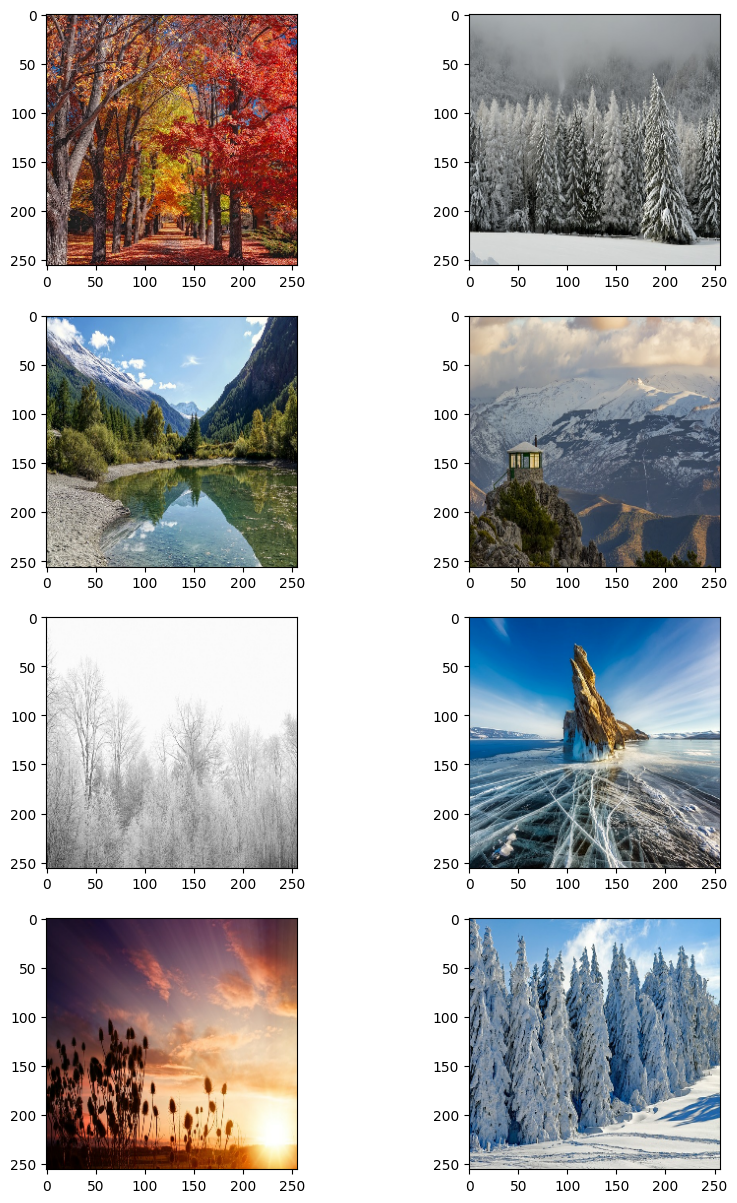

In [ ]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_fall.take(4), train_winter.take(4))):
    real = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ren = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(real)
    ax[i, 1].imshow(ren)
plt.show()

In [ ]:
len(train_fall)

893

In [ ]:
len(train_winter)

900

In [ ]:
class ReflectionPadding2D(layers.Layer):

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [ ]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))


    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))


    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

In [ ]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model



gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")


disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):

        real_x, real_y = batch_data


        with tf.GradientTape(persistent=True) as tape:

            fake_y = self.gen_G(real_x, training=True)

            fake_x = self.gen_F(real_y, training=True)


            cycled_x = self.gen_F(fake_y, training=True)

            cycled_y = self.gen_G(fake_x, training=True)


            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)


            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)


            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)


            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle


            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )


            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F


            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)


        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)


        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)


        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )


        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [ ]:
adv_loss_fn = keras.losses.MeanSquaredError()


def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss



def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)


cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

# **Training the model**

## **20 Epoch**

In [ ]:
print("Started to fit the data")
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_fall, train_winter)),
    epochs=20
)
print("Finished")

Started to fit the data
Epoch 1/20
893/893 [==============================] - 760s 750ms/step - G_loss: 5.5260 - F_loss: 4.8982 - D_X_loss: 0.1638 - D_Y_loss: 0.1208
Epoch 2/20
893/893 [==============================] - 664s 744ms/step - G_loss: 4.6366 - F_loss: 4.1257 - D_X_loss: 0.1550 - D_Y_loss: 0.1231
Epoch 3/20
893/893 [==============================] - 663s 743ms/step - G_loss: 4.0940 - F_loss: 3.9771 - D_X_loss: 0.1419 - D_Y_loss: 0.1618
Epoch 4/20
893/893 [==============================] - 662s 741ms/step - G_loss: 3.8932 - F_loss: 3.7049 - D_X_loss: 0.1722 - D_Y_loss: 0.1619
Epoch 5/20
893/893 [==============================] - 662s 741ms/step - G_loss: 3.7878 - F_loss: 3.5658 - D_X_loss: 0.1726 - D_Y_loss: 0.1739
Epoch 6/20
893/893 [==============================] - 663s 742ms/step - G_loss: 3.6896 - F_loss: 3.5157 - D_X_loss: 0.1826 - D_Y_loss: 0.1703
Epoch 7/20
893/893 [==============================] - 663s 742ms/step - G_loss: 3.5945 - F_loss: 3.4195 - D_X_loss: 0.1854 -

In [ ]:
print("Hello!")

Hello!


In [ ]:
!unzip -q "/content/drive/My Drive/test_fall2winter.zip" -d "./test_dataset"

In [ ]:
test_image_directory = pathlib.Path("/content/test_dataset/test_fall2winter")

In [ ]:
test_fall_path = test_image_directory/'fall'
test_winter_path = test_image_directory/'winter'

In [ ]:
test_file_list_fall = sorted([str(path) for path in test_fall_path.glob('*.png')])
test_file_list_winter = sorted([str(path) for path in test_winter_path.glob('*.png')])

In [ ]:
print(len(test_file_list_fall))
print(len(test_file_list_winter))

12
12


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def load_and_prepocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img,channels=3)
    img = tf.image.resize(img,[256,256])
    img = (img/127.5) - 1
    return img

In [ ]:
def show_prediction(dataset,model,num_examples = 2):
    plt.figure(figsize=(5,5))

    for i,file_path in enumerate(dataset[:num_examples]):
        img = load_and_prepocess_image(file_path)
        prediction = model.predict(tf.expand_dims(img,0))[0]

        ax = plt.subplot(2,num_examples,i+1)
        plt.imshow((img+1)/2)
        plt.title("Real")
        plt.axis("off")


        ax = plt.subplot(2,num_examples,i+num_examples+1)
        plt.imshow((prediction+1)/2)
        plt.title("Converted")
        plt.axis("off")
    plt.show()

1/1 [==============================] - 0s 25ms/step


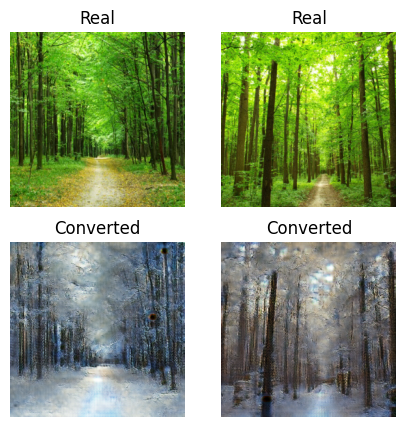

In [ ]:
show_prediction(test_file_list_fall,gen_G,5)

1/1 [==============================] - 0s 22ms/step


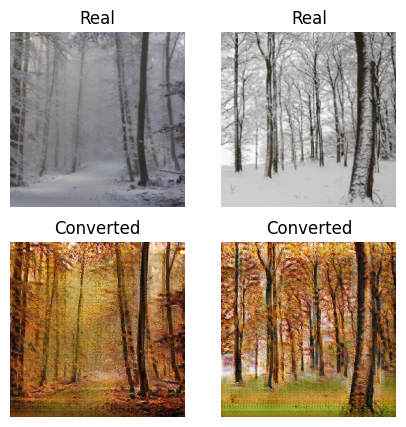

In [ ]:
show_prediction(test_file_list_winter,gen_F,5)

In [ ]:
gen_G.save('/content/cycle_gan_model_gen_G')
gen_F.save('/content/cycle_gan_model_gen_F')
disc_X.save('/content/cycle_gan_model_disc_X')
disc_Y.save('/content/cycle_gan_model_disc_Y')

In [ ]:
!zip -r cycle_gan_model_gen_G.zip /content/cycle_gan_model_gen_G
!zip -r cycle_gan_model_gen_F.zip /content/cycle_gan_model_gen_F
!zip -r cycle_gan_model_disc_X.zip /content/cycle_gan_model_disc_X
!zip -r cycle_gan_model_disc_Y.zip /content/cycle_gan_model_disc_Y

  adding: content/cycle_gan_model_gen_G/ (stored 0%)
  adding: content/cycle_gan_model_gen_G/assets/ (stored 0%)
  adding: content/cycle_gan_model_gen_G/saved_model.pb (deflated 93%)
  adding: content/cycle_gan_model_gen_G/fingerprint.pb (stored 0%)
  adding: content/cycle_gan_model_gen_G/variables/ (stored 0%)
  adding: content/cycle_gan_model_gen_G/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/cycle_gan_model_gen_G/variables/variables.index (deflated 75%)
  adding: content/cycle_gan_model_gen_G/keras_metadata.pb (deflated 95%)
  adding: content/cycle_gan_model_gen_F/ (stored 0%)
  adding: content/cycle_gan_model_gen_F/assets/ (stored 0%)
  adding: content/cycle_gan_model_gen_F/saved_model.pb (deflated 93%)
  adding: content/cycle_gan_model_gen_F/fingerprint.pb (stored 0%)
  adding: content/cycle_gan_model_gen_F/variables/ (stored 0%)
  adding: content/cycle_gan_model_gen_F/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/cycle_gan_mode